In [1]:
# %% IMPORTS

import warnings # Ignore warnings
from learning_lidar.utils import utils
warnings.filterwarnings ( "ignore" )
import os
import yaml
from datetime import datetime,timedelta, time
import astral
from astral.sun import sun
import learning_lidar.utils.global_settings as gs
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
eps = np.finfo(np.float).eps
from dateutil import tz
from learning_lidar.utils.misc_lidar import calc_gauss_curve
from scipy.optimize import curve_fit
import seaborn as sns
from sklearn.linear_model import LinearRegression
import learning_lidar.preprocessing.preprocessing as prep
import calendar
import learning_lidar.generation.generation_utils as gen_utils
# %% Plotting settings
sns.set_theme()
import learning_lidar.utils.vis_utils as vis_utils
import learning_lidar.utils.xr_utils as xr_utils
vis_utils.set_visualization_settings()
wavelengths =gs.LAMBDA_nm().get_elastic()
sns.set_palette(sns.color_palette("tab10"))
# %% Helper Functions

def gauss_fit(x, y, mean_0 = None,sigma_0=None):
	if mean_0:
	    mean= mean_0
	else:
		mean = np.mean(x)
	if sigma_0:
		sigma = sigma_0
	else:
		sigma = np.std(y)**2
	initial_guess = [np.mean(y), max(y), mean, sigma]
	popt, pcov = curve_fit(calc_gauss_curve, x, y,
                           p0=initial_guess,
                           absolute_sigma = True)
	return popt

def func_log(x, a, b,c,d):
    """Return values from a general log function."""
    return a*np.log( b*x + c ) + d

def func_cos(x, a, b,c,d):
    """Return values from a general log function."""
    return a*np.cos(np.deg2rad(b*x) + c) + d

def calc_gauss_width(min_val, max_val, rel_val, FWRM):
	max_rel_ratio = (rel_val-min_val)/(max_val-min_val)
	W =  (FWRM)/(2*np.sqrt(2*np.log(1/max_rel_ratio)))
	return W

def get_params(date, lat, lon):
    loc = astral.Location(('Greenwich', 'England', lat, lon, 'Europe/London'))
    loc.solar_depression = 'nautical'
    sun = loc.sun(date)
    day_light = loc.daylight(date)
    day_len = str(day_light[1] - day_light[0])  # converts from timedelta seconds to HH:mm:ss
    sun_alt = loc.solar_elevation(date)

    return sun['noon'], day_len, sun_alt

def utc2tzloc(utc_dt, location):
	"""
	Convert time zone from UTC to the locations' time zone
	:param utc_dt: datetime.datetime(), UTC time to convert
	:param location: astral.LocationInfo(), location info
	:return: datetime.datetime() , time in locations' time zone
	"""
	to_zone = tz.gettz(location.region)
	from_zone = tz.gettz('UTC')
	utc_dt = utc_dt.replace(tzinfo=from_zone)
	loc_dt = utc_dt.astimezone(to_zone)
	return loc_dt

def tzloc2utc(loc_dt, location):
	"""
	Convert time zone from input location to UTC
	:param loc_dt: datetime.datetime(), time in location time zone to convert
	:param location: astral.LocationInfo(), location info
	:return: datetime.datetime() , time in UTC time zone
	"""
	to_zone = tz.gettz('UTC')
	from_zone = tz.gettz(location.region)
	loc_dt = loc_dt.replace(tzinfo=from_zone)
	utc_dt = loc_dt.astimezone(to_zone)
	return utc_dt

def dt2binscale(dt_time, res_sec = 30):
	"""
	Returns the bin index corresponds to dt_time
	binscale - is the time scale [0,2880], of a daily lidar bin index from 00:00:00 to 23:59:30.
	The lidar has a bin measure every 30 sec, in total 2880 bins per day.
	:param dt_time: datetime.datetime object
	:return: binscale - float in [0,2880]
	"""
	res_minute = 60/res_sec
	res_hour = 60*res_minute
	res_musec = (1e-6)/res_sec
	tind = dt_time.hour*res_hour + dt_time.minute*res_minute + dt_time.second/res_sec + dt_time.microsecond*res_musec
	return tind

def binscale2dt(tind,day_date=datetime.today(), res_sec=30):
    dt_time = day_date+timedelta(seconds = res_sec)*tind
    return dt_time

sun_dt = lambda day,type: sun(loc.observer,day)[type]

def dt_delta2time(dt_delta):
	hours, remainder = divmod(dt_delta.seconds, 3600)
	minutes, seconds = divmod(remainder, 60)
	m_seconds = dt_delta.microseconds
	dt_time = time ( hours,minutes,seconds,m_seconds)
	return dt_time
# %%
# TODO - convert to py module

## Daily Sun Elevation
- Explore daily and yearly $\alpha_{\rm sun}$

In [3]:
station_name = 'haifa'
station = gs.Station (station_name = station_name )
cur_day = datetime(2017,10,4)
day_0 = datetime(2017,4,4)
timezone = 'UTC'
cur_day_str = cur_day.strftime('%Y-%m-%d')
loc = astral.LocationInfo("Haifa",'Israel',timezone,station.lat,station.lon)
loc.observer.elevation = station.altitude

#### 1. Sun elevation during the year :
- Extracting the sun elevation at noon time for every day during 2017

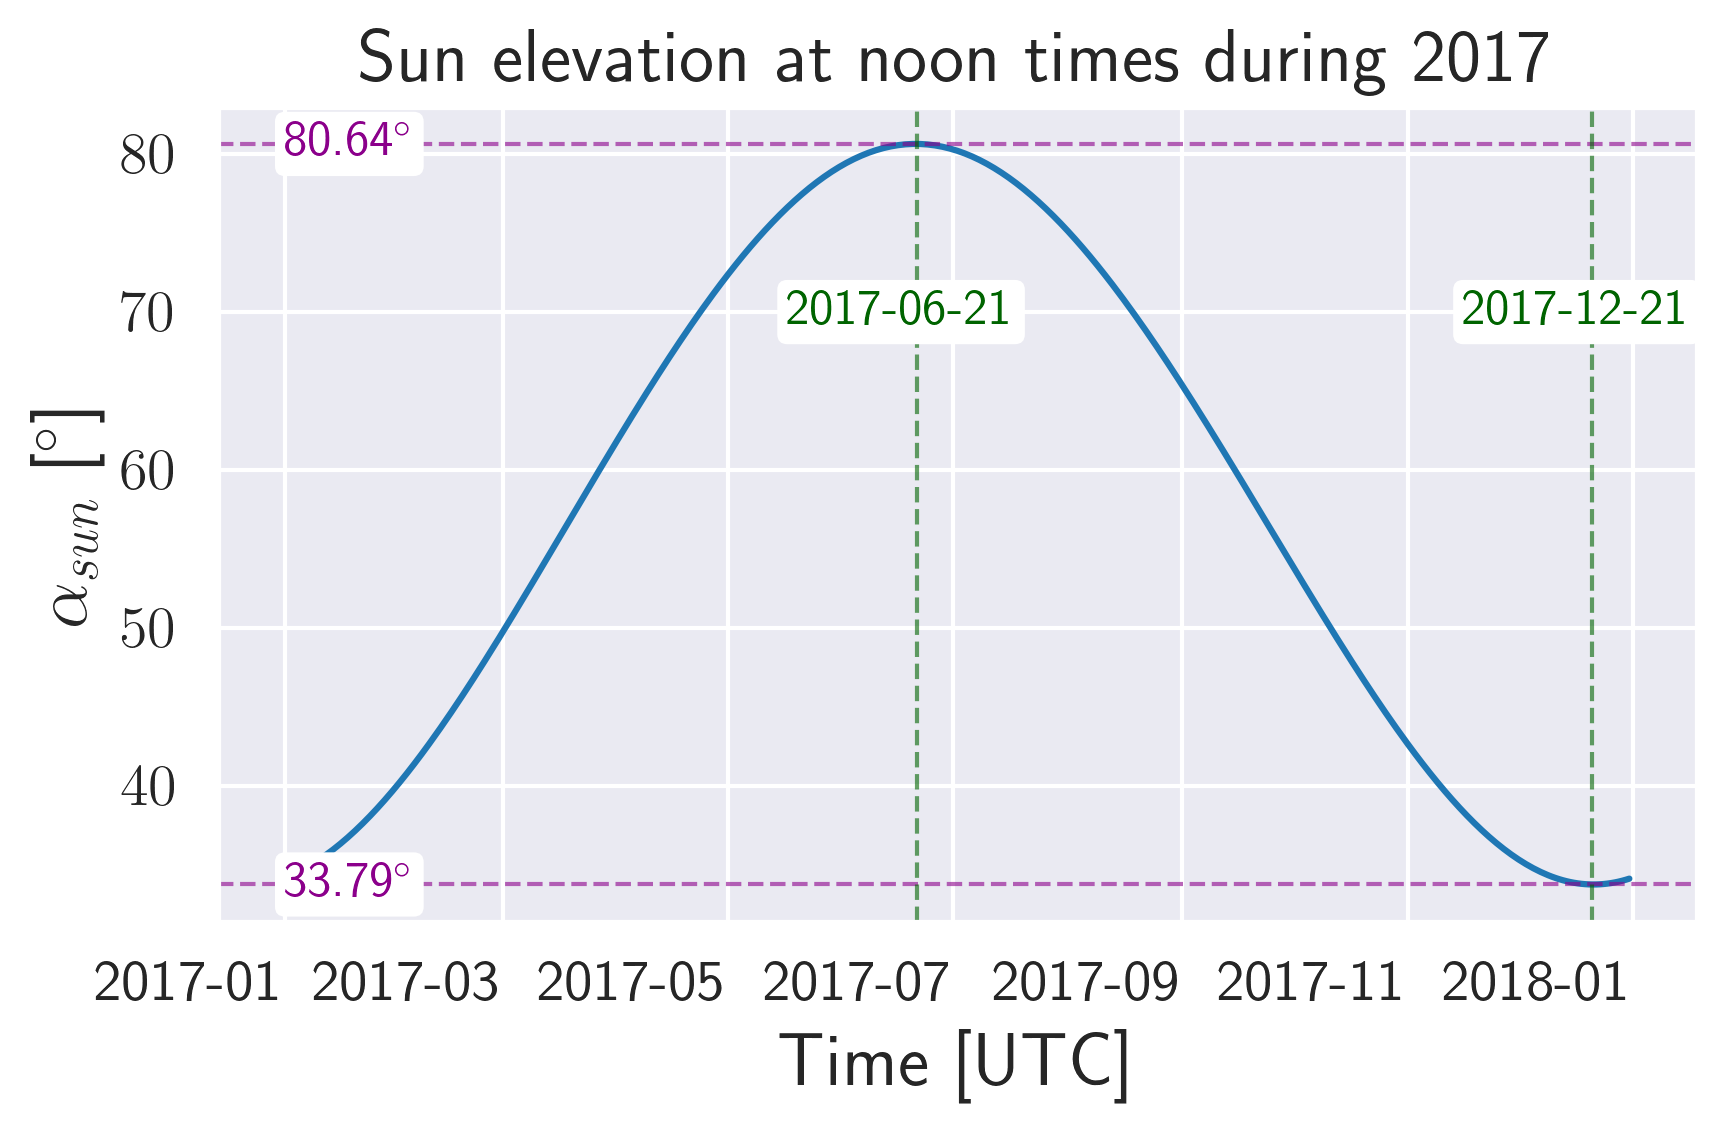

In [9]:
# %% Sun elevation at noon time per day:
year_days = pd.date_range(start = datetime(2017,1,1),end = datetime(2017,12,31),freq = 'D',tz = 'UTC')
sun_noons = [sun(loc.observer,c_day)['noon'] for c_day in year_days]
sun_elevations = [astral.sun.elevation(loc.observer,dt) for dt in sun_noons]
ds_year = xr.Dataset( data_vars = {'sunelevation':(('Time'),sun_elevations)},
                 coords = {'Time':year_days.values})
ds_year.sunelevation.attrs ={'long_name': r'$\alpha_{sun}$','units':r'$^{\circ}$' }
ds_year.Time.attrs ={"units":fr"{timezone}"}

# Maximum sun elevation during 2017:
max_year_elevation = np.max(ds_year.sunelevation.values)
day_max_num = np.argmax(ds_year.sunelevation.values)
day_max =  ds_year.Time.values[day_max_num]
day_max_str = utils.dt64_2_datetime(day_max).strftime('%Y-%m-%d')

# Minimum sun elevation during 2017:
min_year_elevation = np.min(ds_year.sunelevation.values)
day_min_num = np.argmin(ds_year.sunelevation.values)
day_min_num = np.argmin(ds_year.sunelevation.values)
day_min =  ds_year.Time.values[day_min_num]
day_min_str = utils.dt64_2_datetime(day_min).strftime('%Y-%m-%d')

# %%Plot sun elevation at noon times
fig, ax = plt.subplots(ncols=1,nrows=1)
ds_year.sunelevation.plot(ax=ax)
ax.annotate(fr'{day_max_str}',fontweight='bold',fontsize =12,
            xy=(day_max,max_year_elevation-10),color='darkgreen',va="center",
            xytext=(ds_year.Time.values[day_max_num-35],70),
            bbox=dict(boxstyle='round,pad=0.2',ec="none", fc=[1,1,1]),
            )
ax.annotate(fr'{day_min_str}',
            fontweight='bold',fontsize =12,color='darkgreen',
            xy=(day_min,30+min_year_elevation),va="center",
            bbox=dict(boxstyle='round,pad=0.2',ec="none", fc=[1,1,1]),
            xytext=(ds_year.Time.values[day_min_num-35],70),
            )
ax.annotate(fr'{min_year_elevation:.2f}$^\circ$',
            fontweight='bold',fontsize =12,color='darkmagenta',
            xy=(day_min,min_year_elevation),va="center",
            bbox=dict(boxstyle='round,pad=0.2', fc=[1,1,1],ec="none"),
            xytext=(ds_year.Time.values[0],min_year_elevation)
            )
ax.annotate(fr'{max_year_elevation:.2f}$^\circ$',
            fontweight='bold',fontsize =12,color='darkmagenta',
            xy=(day_max,max_year_elevation),va="center",
            bbox=dict(boxstyle='round,pad=0.2', fc=[1,1,1],ec="none"),
            xytext=(ds_year.Time.values[0],max_year_elevation)
            )
ax.axhline(y=min_year_elevation, xmin=0.0, xmax=1.0,alpha=.6,
           color='darkmagenta',linestyle='--',linewidth=1)
ax.axhline(y=max_year_elevation, xmin=0.0, xmax=1.0,alpha=.6,
           color='darkmagenta',linestyle='--',linewidth=1)
ax.axvline(x=ds_year.Time.values[day_min_num], ymin=0.0, ymax=1.0,alpha=.6,
           color='darkgreen',linestyle='--',linewidth=1)
ax.axvline(x=ds_year.Time.values[day_max_num], ymin=0.0, ymax=1.0,alpha=.6,
           color='darkgreen',linestyle='--',linewidth=1)
ax.xaxis.set_major_formatter(vis_utils.MONTHFORMAT)
ax.xaxis.set_tick_params(rotation=0)
plt.title('Sun elevation at noon times during 2017')
plt.tight_layout()
plt.show()

# %%

#### 2. Sun elevation during the day :

In [10]:
# %% Create daily dataset of sun elevation, azimuth, daylight hours
day_sun = sun(loc.observer,cur_day)
day_times = pd.date_range(start = cur_day,
                          end = (cur_day+timedelta(hours = 24)-timedelta(seconds = 30)),
                          freq = '30S',tz = 'UTC')
df = pd.DataFrame(data = day_times, columns = ['Time'])
ds_day = xr.Dataset( data_vars =
                     {'sunazimuth':(('Time'), df.Time.apply(lambda x: astral.sun.azimuth(loc.observer,x))),
                      'sunelevation':(('Time'), df.Time.apply(lambda x: astral.sun.elevation(loc.observer,x)) )},
                     coords = {'Time':df.Time.values})
ds_day.sunelevation.attrs ={'long_name': r'$\alpha_{sun}$','units':r'$^{\circ}$' }
ds_day.Time.attrs ={"units":fr"{timezone}"}
day_light_sun = ds_day.sunelevation.copy(deep=True)
# %%

#### Gaussian curve fit of sun elevation during daylight hours:
 - Fitting to : $y(t) = A + H \cdot \exp \bigg( -\frac {(t - t_0) ^ 2}{2 \cdot W ^2}\bigg) $
 - Initial guess : $t_0=t_{\rm noon-TST}$
 - Initial guess : $ W = \frac{\Delta t_{\rm daylight}}{2\sqrt({2\ln({\frac{1}{\alpha_{\rm ratio}}})}) }$, $\alpha_{\rm ratio} =\frac{\alpha_{\rm twilight} - \alpha_{\rm min}}{\alpha_{\rm noon}-\alpha_{\rm min}}$
> Assuning:
> - A parametric curve $t$ with 2880 bins (similar to lidar's bins per day).
> - $\alpha_{\rm twilight}=-6^\circ$
> - $\Delta t_{\rm daylight} = t_{\rm dusk} -  t_{\rm dawn}$

Sigma fit:621.89, Sigma init estimated:629.40 
Mean fit:1132.95, Mean init estimated:1137.47 


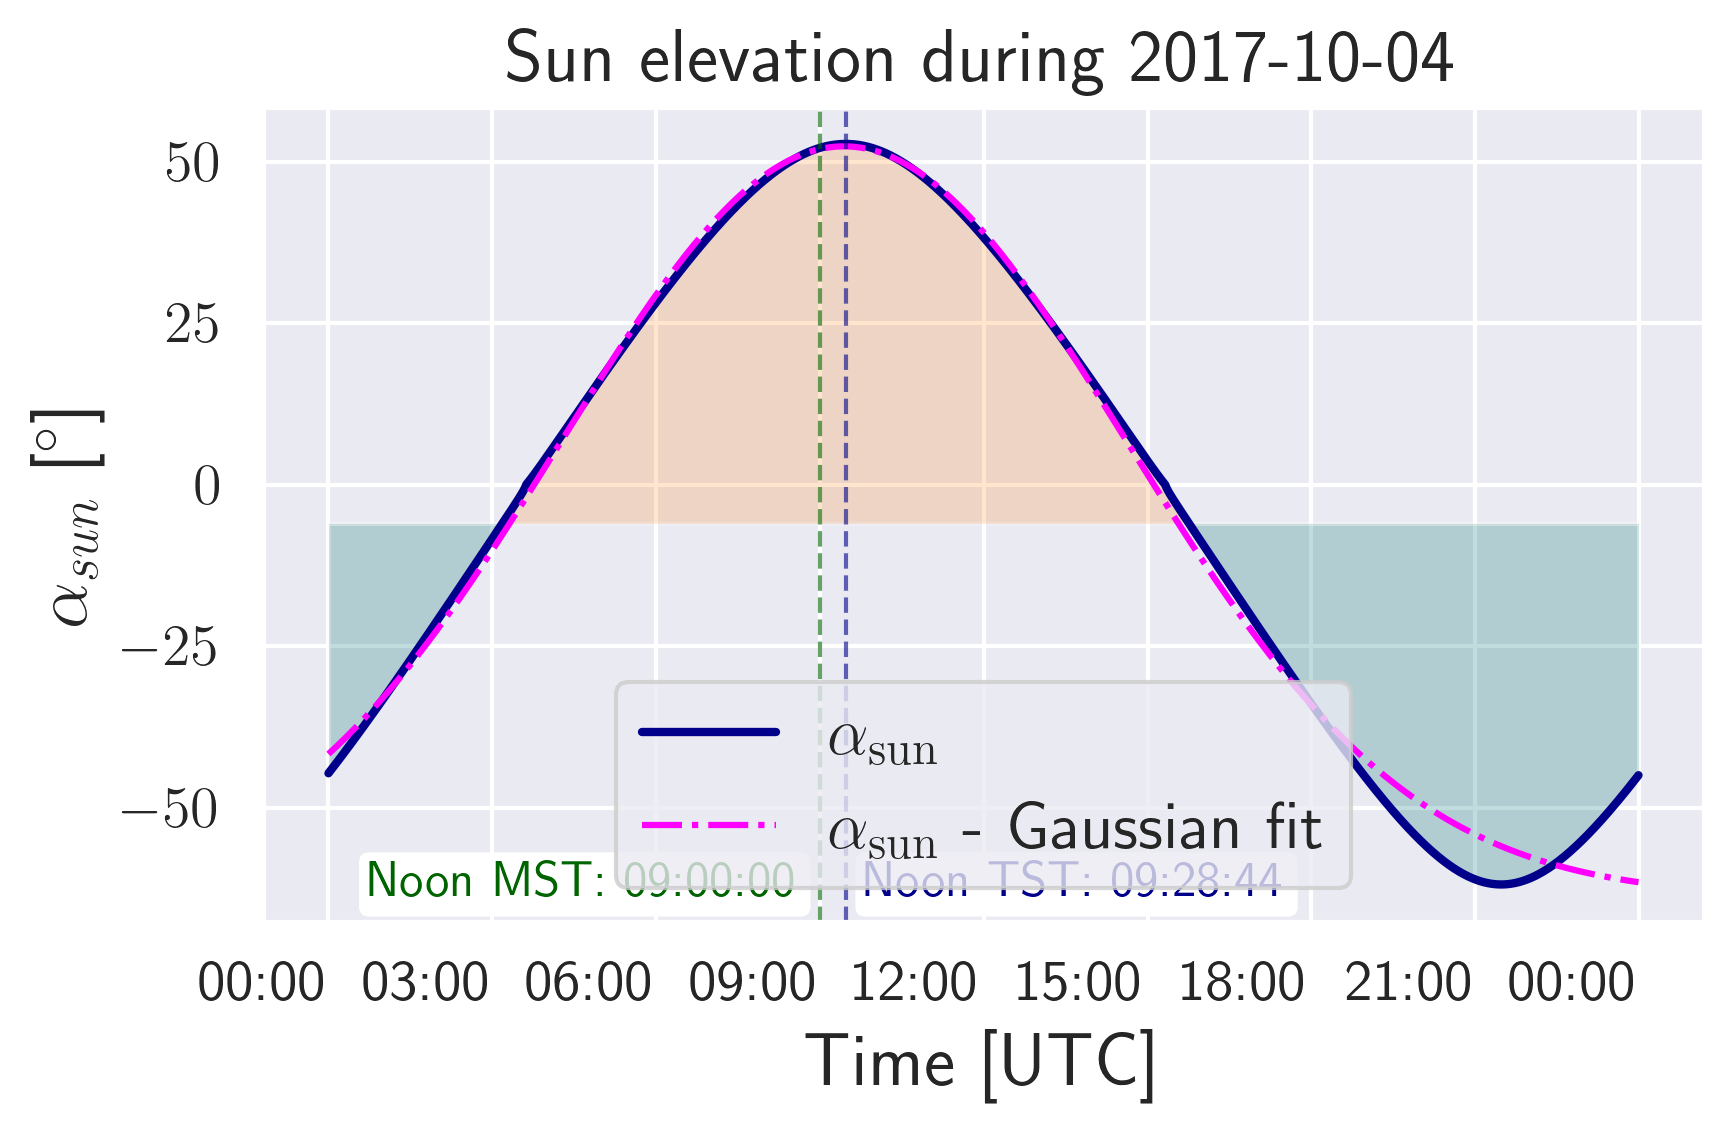

In [11]:
bins_per_day = station.total_time_bins
t = np.arange(0,bins_per_day)

# %% Initial guess of mean - at noon time / or when the sun elevation is at maximum angle.
dawn_dusk_angle= -6
day_light_sun[day_light_sun<dawn_dusk_angle] = dawn_dusk_angle
MST_noon = cur_day + timedelta(hours = 12)
MST_noon = tzloc2utc(MST_noon,loc)
TST_noon = day_sun['noon']
mean0 = dt2binscale(TST_noon, res_sec = 30)

# %% Initial guess of std (width of curve) - using width gaussian properties:
dawn_to_dusk = (day_sun['dusk']-day_sun['dawn'])
min_angle = ds_day.sunelevation.values.min()
max_angle = ds_day.sunelevation.values.max()
sigma0 = calc_gauss_width(min_angle, max_angle, dawn_dusk_angle, dt2binscale(dawn_to_dusk+day_0))
# %% Gaussian fit to sun elevation

y = ds_day.sunelevation.values.copy()
A3, H3, x0_3, sigma3 = gauss_fit(t,y,mean_0 = mean0,sigma_0 =sigma0)
fit3 = calc_gauss_curve(t, *gauss_fit(t, y,mean_0 = mean0,sigma_0 = sigma0))

print(f"Sigma fit:{sigma3 :.2f}, Sigma init estimated:{sigma0 :.2f} ")
print(f"Mean fit:{x0_3 :.2f}, Mean init estimated:{mean0 :.2f} ")

# %% Plot curve and fit
sns.set_palette(sns.color_palette("tab10"))
fig, ax = plt.subplots(ncols=1,nrows=1)
ds_day.sunelevation.plot(ax = ax,label = r'$\alpha_{\rm sun}$',color='darkblue',linewidth=2.0)
ax.fill_between(ds_day.Time, day_light_sun, ds_day.sunelevation, alpha=0.2)
ax.fill_between(ds_day.Time, day_light_sun, dawn_dusk_angle, alpha=0.2)
ax.fill_between(ds_day.Time, ds_day.sunelevation, day_light_sun, alpha=0.1)
ax.plot(ds_day.Time, fit3 , '-.', label=r'$\alpha_{\rm sun}$ - Gaussian fit',color='fuchsia')
ax.axvline(x=TST_noon, ymin=0.0, ymax=1.0,alpha=.6,
           color='darkblue',linestyle='--',linewidth=1)
ax.axvline(x=MST_noon, ymin=0.0, ymax=1.0,alpha=.6,
           color='darkgreen',linestyle='--',linewidth=1)
TST_noon_str = fr"Noon TST: {TST_noon.strftime('%H:%M:%S')}"
MST_noon_str = fr"Noon MST: {MST_noon.strftime('%H:%M:%S')}"
if MST_noon<TST_noon:
	left_title = MST_noon_str
	left_c = 'darkgreen'
	left_x = TST_noon
	right_title = TST_noon_str
	right_c = 'darkblue'
	right_x = MST_noon
else:
	left_title = TST_noon_str
	left_c = 'darkblue'
	left_x = TST_noon
	right_title = MST_noon_str
	right_c = 'darkgreen'
	right_x = TST_noon
ax.annotate(right_title,
            fontweight='bold',fontsize =12,color=right_c,
            xy=(right_x,y.min()),
            ha="left", va = "center",
            bbox=dict(boxstyle='round,pad=0.2',ec="none", fc=[1,1,1]),
            xytext=(right_x+timedelta(minutes =50),y.min()))
ax.annotate(left_title,
            fontweight='bold',fontsize =12,color=left_c,
            xy=(left_x,y.min()),
            ha="right", va = "center",
            bbox=dict(boxstyle='round,pad=0.2',ec="none", fc=[1,1,1]),
            xytext=(left_x-timedelta(minutes = 50),y.min()))
ax.xaxis.set_major_formatter(vis_utils.TIMEFORMAT)
ax.xaxis.set_tick_params(rotation=0)
plt.title(f'Sun elevation during {cur_day_str}')
plt.legend()
plt.tight_layout()
plt.show()

#### 3. Solar Irradiance vs. Solar Elevation
 - Fitting irradiance according to :$f(\alpha_{sun}) = a\cdot \cos(b \cdot \alpha_{sun} + c) + d$

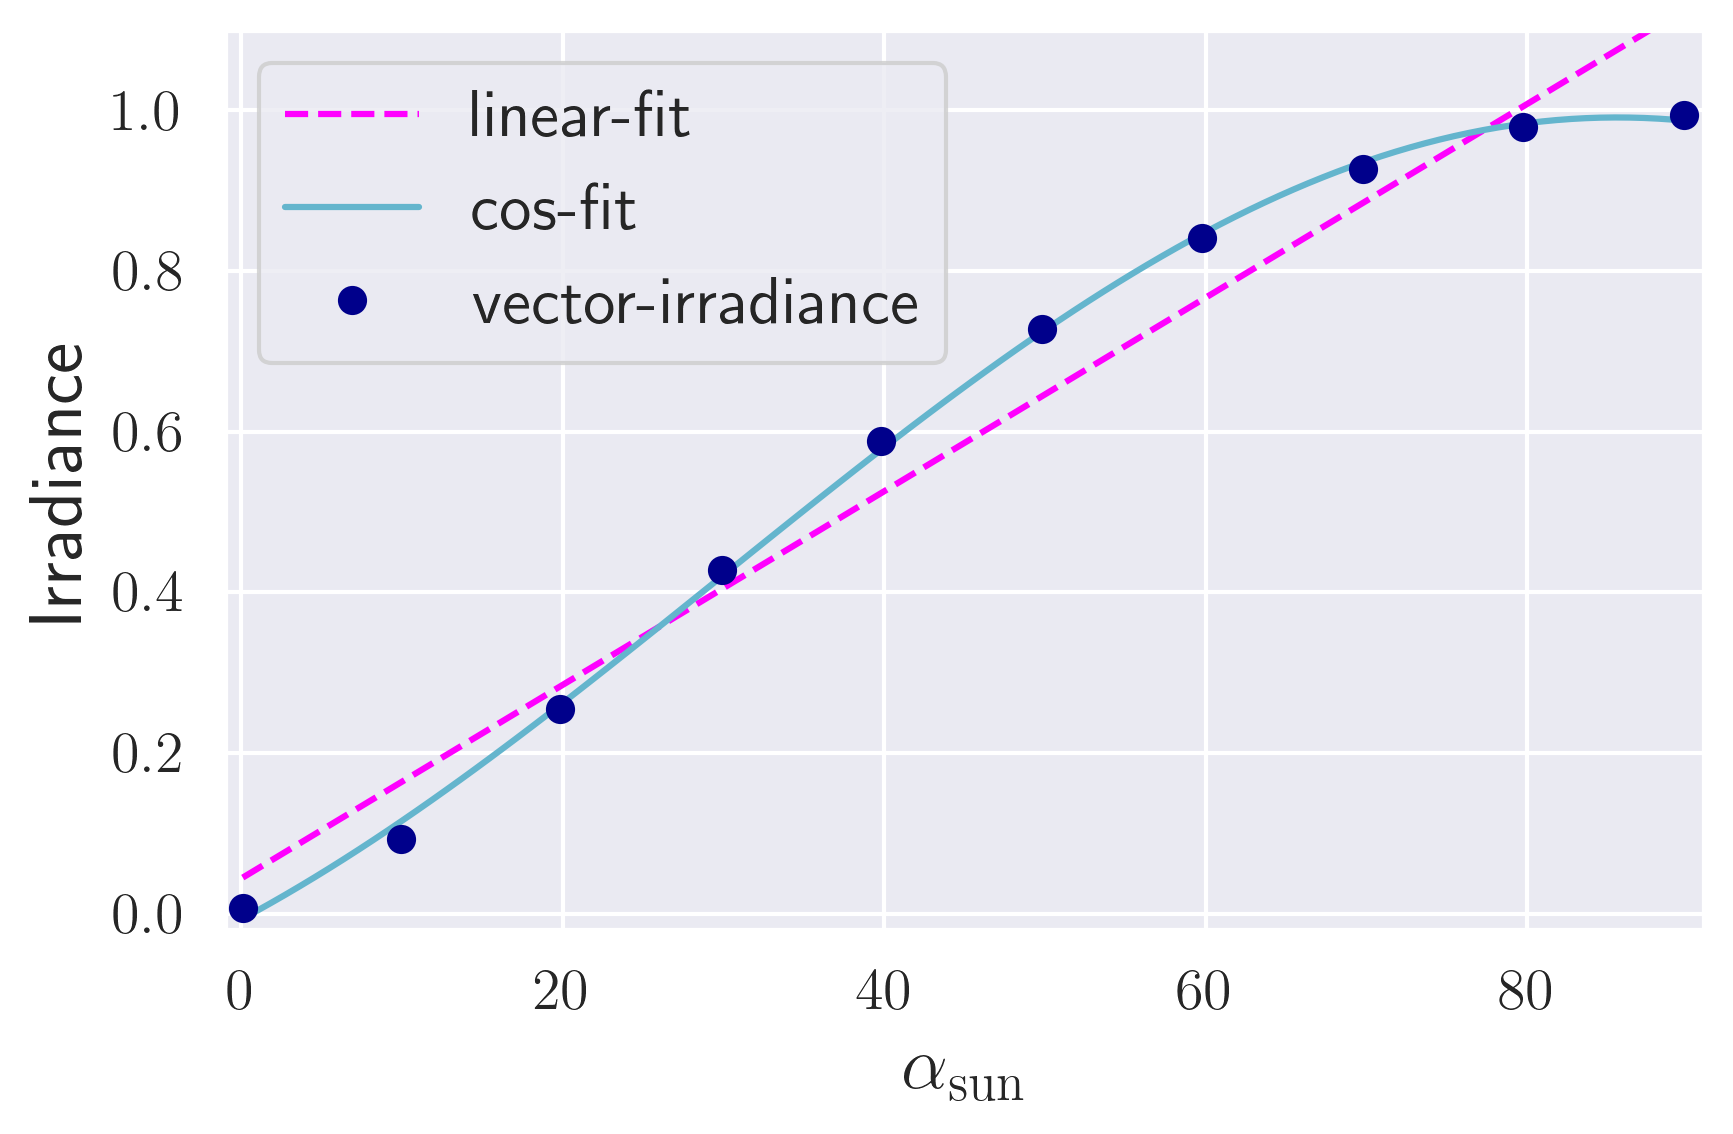

In [12]:
# %% Load irradiance - solar elevation data
data_folder = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath(os.curdir))), 'data')
csv_iradiance_elevation = r'irradiance_solarElevation.csv'
bg_signal_folder = os.path.join(data_folder,'background_signal')
csv_name = os.path.join(bg_signal_folder,csv_iradiance_elevation)
df_iradiance_solar =pd.read_csv(csv_name)
df_iradiance_solar.rename(columns =
                          {'X_vector_irradiance':r'$\alpha_{\rm sun}$',
                           'Y_vector_irradiance':'vector-irradiance'},
                          inplace = True)
X = df_iradiance_solar[r'$\alpha_{\rm sun}$'].values.reshape(-1, 1)
Y = df_iradiance_solar['vector-irradiance'].values.reshape(-1, 1)
# %% Linear fit :
linear_regressor = LinearRegression() # create object for the class
linear_regressor.fit(X[:], Y[:]) # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
# %% Cos() - fit :
popt, pcov = curve_fit(func_cos, X[:,0], Y[:,0])
angles = np.linspace(0,90,100,endpoint=True)
cos_fit = func_cos(angles,popt[0],popt[1],popt[2],popt[3])
# %% Plot data + fitting curves
fig, ax = plt.subplots(ncols=1,nrows=1)
ax.plot(X, Y_pred, color='magenta',label = 'linear-fit',linestyle='--')
ax.plot(angles, cos_fit, color='c',label = 'cos-fit')
df_iradiance_solar.plot(x=r'$\alpha_{\rm sun}$',
                        y='vector-irradiance',
                        style='o',
                        c="darkblue",
                        ax=ax)
plt.ylabel(r'Irradiance')
plt.legend()
plt.xlim([-1,91])
plt.ylim([-0.02,1.1])
plt.tight_layout()
plt.show()
# %%

## Daily background
- Create a mean background noise $<p_{bg}>$

#### 1. Load parameters of gaussian curve fit

In [13]:
bg_params_path = os.path.join(bg_signal_folder,'curve_params.yml')
with open(bg_params_path,'r') as ymlfile:
        params = yaml.safe_load(ymlfile)

#### 2.Time resolution adjustments of the curve fitting
- The ratio is to adjust time bins $t$ to lidar sampling bins (delta_t=30[s] )
- the estimated curve refer to delta_t=100[s], bins_per_day=864

In [14]:
bins_ratio = bins_per_day/params['bins_per_day']
factors = [1/2,1,1/7] # This are the original factor of the data for [UV,G,IR]

#### 3. Calculate bg mean of the original day - 04/04/2014

In [15]:
# %%Generate background signal'''
bg_new = []
high_curves =[]
low_curves =[]
mean_curves=[]
day_times_4_4_2017 = pd.date_range(start = day_0,end = (day_0 +timedelta(hours = 24)-timedelta(seconds = 30)),freq = '30S',tz = 'UTC')
df_4_4_2017 = pd.DataFrame(data = day_times_4_4_2017, columns = ['Time'])
for chan,factor in zip(['UV','G','IR'],factors):
    prms_h = params[chan]['high']
    prms_l = params[chan]['low']
    ''' Calculating bounding curves series'''
    high_curve = factor*calc_gauss_curve(t,prms_h['A'],prms_h['H'],bins_ratio*prms_h['t0'],bins_ratio*prms_h['W'])
    low_curve = factor*calc_gauss_curve(t,prms_l['A'],prms_l['H'],bins_ratio*prms_l['t0'],bins_ratio*prms_l['W'])
    high_curves.append(high_curve)
    low_curves.append(low_curve)
    ''' Generating new random series of background signal'''
    mean_val = 0.5*(low_curve+high_curve)
    mean_curves.append(mean_val)
    std_val = 0.5*(high_curve-low_curve)
    bg_new_chan = mean_val.reshape(bins_per_day,1)+\
                  np.matmul(np.diagflat(std_val),np.random.randn(bins_per_day,1))
    bg_new.append(bg_new_chan)
bg_new = np.array(bg_new)
bg_new[bg_new<0]=eps
bgmean= xr.DataArray(dims=('Wavelength','Time'),data=bg_new.reshape((3,bins_per_day)))
bgmean = bgmean.assign_coords({"Wavelength":wavelengths,"Time":df_4_4_2017.Time.values})
bgmean.Wavelength.attrs = {'long_name':r'$\lambda$','units':r'$\rm nm$'}
bgmean.attrs = {'info':'Background Mean Signal',
                'long_name':r'$<p_{bg}>$',
                'units':r'$photons$',
                'name':'pbg'}
bg_max = bgmean.copy(deep=True).assign_attrs({'info':'Max Background Signal'})
bg_max.data=np.array(high_curves).reshape((3,bins_per_day))
bg_min = bgmean.copy(deep=True).assign_attrs({'info':'Min Background Signal'})
bg_min.data = np.array(low_curves).reshape((3,bins_per_day))
bg_mean = bgmean.copy(deep=True).assign_attrs({'info':'Mean Background Signal'})
bg_mean.data = np.array(mean_curves).reshape((3,bins_per_day))

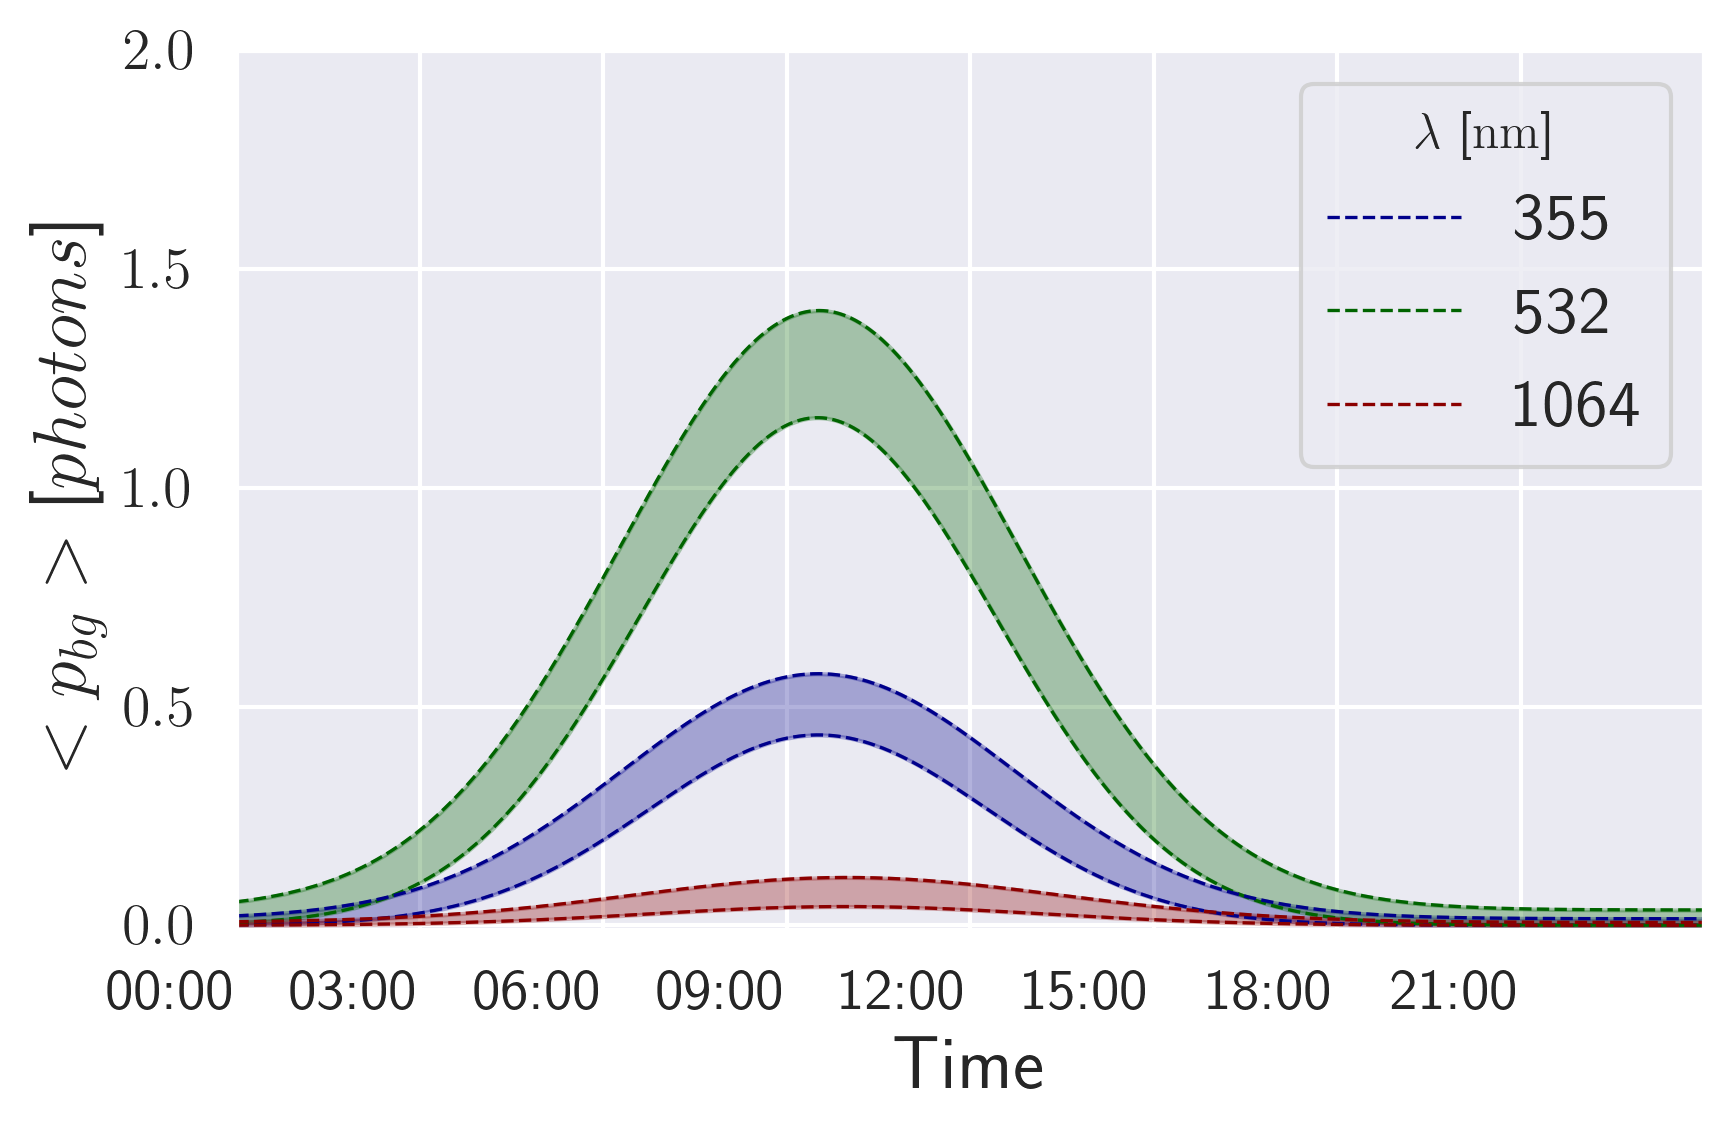

In [17]:
# %%Plot background signal
sns.set_palette(sns.color_palette(vis_utils.COLORS))
fig, ax = plt.subplots(ncols=1,nrows=1)
for i,(curve_h,curve_l,mean_val,c,chan,wavelength) in \
        enumerate(zip(high_curves,low_curves,mean_curves,vis_utils.COLORS,['UV','G','IR'],wavelengths)):
	ax.fill_between(bgmean.Time,curve_h,curve_l,alpha= .3,color=c)
bg_min.plot(hue='Wavelength',ax=ax,linewidth=0.8,linestyle = '--')
bg_max.plot(hue='Wavelength',ax=ax,linewidth=0.8,linestyle = '--')
SHOW_MEAN   = False
if SHOW_MEAN:
    bgmean.plot(hue='Wavelength',ax=ax,linewidth=0.8)
ax.xaxis.set_major_formatter(vis_utils.TIMEFORMAT)
ax.xaxis.set_tick_params(rotation=0)
ax.set_xlim([bgmean.Time.values[0], bgmean.Time.values[-1]])
ax.set_ybound([-.01,2])
plt.tight_layout()
plt.show()
# %%

#### 4. Calculating Gaussian curve parameters for a new day:
- The mean is set based on the time shifting of the mean curves from 04/04/2017:
$\Delta t_{\rm shift} = \frac{T_{\rm noon0} - t_{0-curve}}{\Delta t_{\rm daylight0}}$ $T_{\rm new-curve} = T_{\rm noon} - \Delta t_{\rm daylight} \cdot \Delta t_{\rm shift}$
- The amplitude is set according to the relation of angle-irradiance

Ration elevation for 2017-10-04: 0.87
UV low: A=0.00, H=0.38, W=318.85, t0=1114.82,W_dt=02:39:25 ,t0_dt:09:17:24
UV high: A=0.01, H=0.49, W=372.60, t0=1114.82, W_dt=03:06:18 , t0_dt:09:17:24
G low: A=0.00, H=1.01, W=335.66, t0=1113.27,W_dt=02:47:49 ,t0_dt:09:16:37
G high: A=0.03, H=1.19, W=379.31, t0=1116.38, W_dt=03:09:39 , t0_dt:09:18:11
IR low: A=0.00, H=0.04, W=373.17, t0=1166.77,W_dt=03:06:35 ,t0_dt:09:43:23
IR high: A=0.01, H=0.09, W=414.15, t0=1166.77, W_dt=03:27:04 , t0_dt:09:43:23


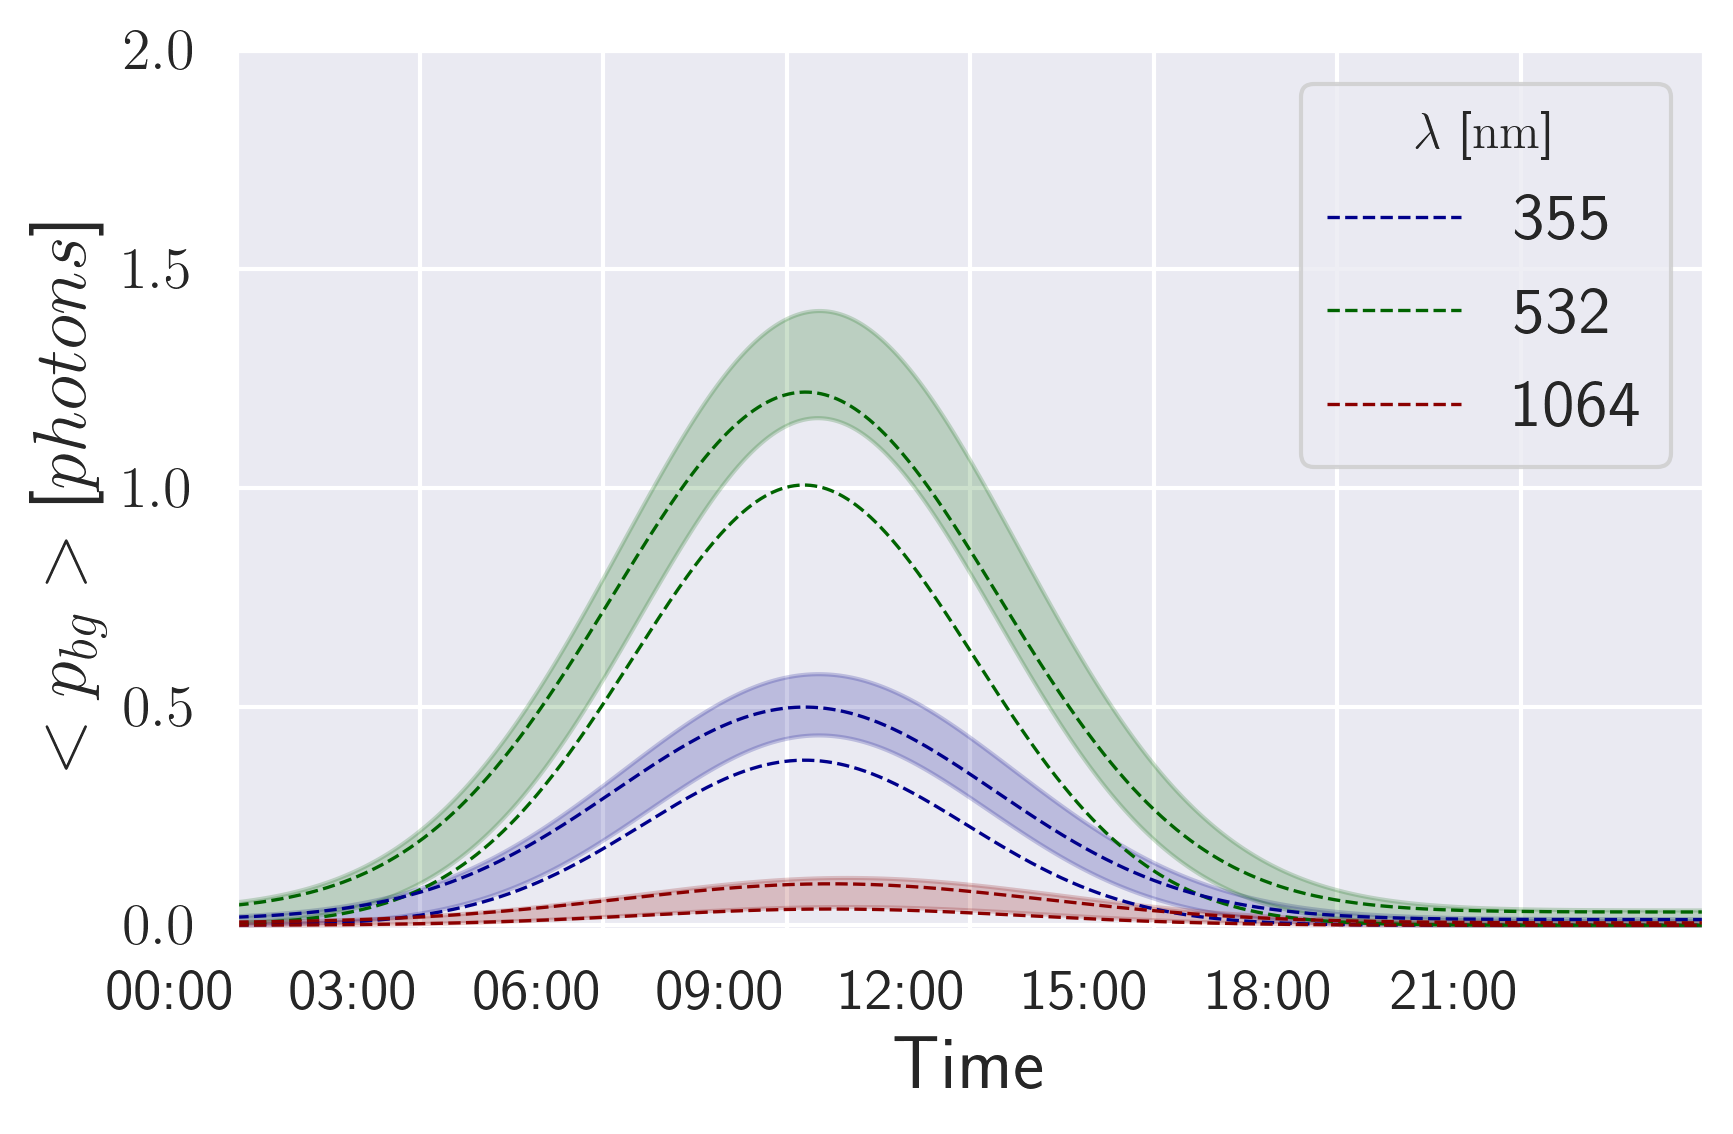

In [18]:
# %%Shifted mean of the curve
tbin_dusk = dt2binscale(day_sun['dusk'])
tbin_dawn = dt2binscale(day_sun['dawn'])
tbin_noon_tst = dt2binscale(day_sun['noon'])
day_bins_length = (tbin_dusk-tbin_dawn)

day_sun0 = sun(loc.observer,day_0)
day_bins_length_0 = dt2binscale(day_sun0['dusk']) - dt2binscale(day_sun0['dawn'])
tbin_noon_tst_0 = dt2binscale(day_sun0['noon'])

# %% Calc elevation ratio
max_elevation_0 =  astral.sun.elevation(loc.observer,day_sun0['noon'])

# %%
day_max_elevation= ds_day.sunelevation.values.max()
iradiance_orig_cos = func_cos(max_elevation_0,popt[0],popt[1],popt[2],popt[3])
iradiance_day_cos = func_cos(day_max_elevation,popt[0],popt[1],popt[2],popt[3])

ratio_elevation = iradiance_day_cos/iradiance_orig_cos
print(f"Ration elevation for {cur_day_str}: {ratio_elevation:.2f}")

# %% Calculate curves parameters
max_new_curves = []
min_new_curves = []
mean_new_curves = []
mean_new_signal = []
for i,(curve_h,curve_l,mean_val,c,chan) in \
        enumerate(zip(high_curves,low_curves,mean_curves,vis_utils.COLORS,['UV','G','IR'])):
	prms_h = params[chan]['high']
	prms_l = params[chan]['low']
	t0 = bins_ratio*prms_l['t0']- day_bins_length_0/2
	t1 = bins_ratio*prms_l['t0']+ day_bins_length_0/2

	A_l  = prms_l['A']*ratio_elevation*factors[i]
	H_l = prms_l['H']*ratio_elevation*factors[i]

	# calculating dx_l for 4/4/2017
	dx_l = (tbin_noon_tst_0-(bins_ratio*prms_l['t0']))/(day_bins_length_0)
	t0_l = tbin_noon_tst - dx_l*day_bins_length

	photons_twilight_l = 0.5*(curve_l[int(t1)]+ curve_l[int(t0)])
	max_val = (prms_l['H']+prms_l['A'])*ratio_elevation*factors[i]
	min_val = (prms_l['A'])*ratio_elevation*factors[i]
	W_l = calc_gauss_width(min_val, max_val, photons_twilight_l, day_bins_length)

	min_new = calc_gauss_curve(t, A_l, H_l , t0_l,W_l )
	min_new_curves.append(min_new)
	print(f"{chan} low: A={A_l:.2f}, H={H_l:.2f}, W={W_l:.2f},"
	      f" t0={t0_l:.2f},W_dt={binscale2dt(W_l,cur_day).strftime('%H:%M:%S')} ,"
	      f"t0_dt:{binscale2dt(t0_l,cur_day).strftime('%H:%M:%S')}")

	A_h  = prms_h['A']*ratio_elevation*factors[i]
	H_h = prms_h['H']*ratio_elevation*factors[i]

	# calculating dx_h for 4/4/2017
	dx_h = (tbin_noon_tst_0-(bins_ratio*prms_h['t0']))/(day_bins_length_0)
	t0_h = tbin_noon_tst - dx_h*day_bins_length


	photons_twilight_h = 0.5*(curve_h[int(t1)]+ curve_h[int(t0)])
	max_val = (prms_h['H']+prms_h['A'])*ratio_elevation*factors[i]
	min_val = (prms_h['A'])*ratio_elevation*factors[i]
	W_h = calc_gauss_width(min_val, max_val, photons_twilight_h, day_bins_length)

	max_new = calc_gauss_curve(t, A_h, H_h , t0_h, W_h )
	max_new_curves.append(max_new)
	print(f"{chan} high: A={A_h:.2f}, H={H_h:.2f}, W={W_h:.2f},"
	      f" t0={t0_h:.2f}, W_dt={binscale2dt(W_h,cur_day).strftime('%H:%M:%S')} ,"
	      f" t0_dt:{binscale2dt(t0_h,cur_day).strftime('%H:%M:%S')}")

	mean_new = 0.5*(max_new+min_new)
	mean_new_curves.append(mean_new)

	std_val = 0.5*(max_new-min_new)
	bg_new_sig = mean_new.reshape(bins_per_day,1)+\
	             np.matmul(np.diagflat(std_val),np.random.randn(bins_per_day,1))
	mean_new_signal.append(bg_new_sig)

	del min_new,max_new,mean_new,bg_new_sig
# %% Generate dataset per type of curve
bg_max_new = bgmean.copy(deep=True)
bg_max_new.attrs['info'] = 'Background Max Signal'
bg_max_new.data=np.array(max_new_curves).reshape((3,bins_per_day))
bg_min_new = bgmean.copy(deep=True)
bg_min_new.attrs['info'] = 'Background Min Signal'
bg_min_new.data = np.array(min_new_curves).reshape((3,bins_per_day))
bg_mean_new = bgmean.copy(deep=True)
bg_mean_new.attrs['info'] = 'Background Mean Signal'
bg_mean_new.data = np.array(mean_new_curves).reshape((3,bins_per_day))
bg_signal_new = bgmean.copy(deep=True)
bg_signal_new.attrs['info'] = 'Background Mean Signal'
bg_signal_new.data = np.array(mean_new_signal).reshape((3,bins_per_day))
# %%Plot the new curves
fig, ax = plt.subplots(ncols=1,nrows=1)
for i,(curve_h,curve_l,mean_val,c,chan,wavelength) in\
        enumerate(zip(high_curves,low_curves,mean_curves,vis_utils.COLORS,['UV','G','IR'],wavelengths)):
	ax.fill_between(bgmean.Time,curve_h,curve_l,alpha= .2,color=c)

bg_min_new.plot(hue='Wavelength',ax=ax,linewidth=0.8,linestyle = '--')
bg_max_new.plot(hue='Wavelength',ax=ax,linewidth=0.8,linestyle = '--')
SHOW_MEAN = False
if SHOW_MEAN:
    bg_mean_new.plot(hue='Wavelength',ax=ax,linewidth=0.8)
SHOW_NEW = False
if SHOW_NEW:
    bg_signal_new.plot(hue='Wavelength',ax=ax,linewidth=0.8)
ax.xaxis.set_major_formatter(vis_utils.TIMEFORMAT)
ax.xaxis.set_tick_params(rotation=0)
ax.set_ybound([-.01,2])
ax.set_xlim([bg_max_new.Time.values[0], bg_max_new.Time.values[-1]])
plt.tight_layout()
plt.show()

#### 4. Calculating Gaussian curve parameters for any day of 2017

### 1. Irradiance vs sun elevation at noon times

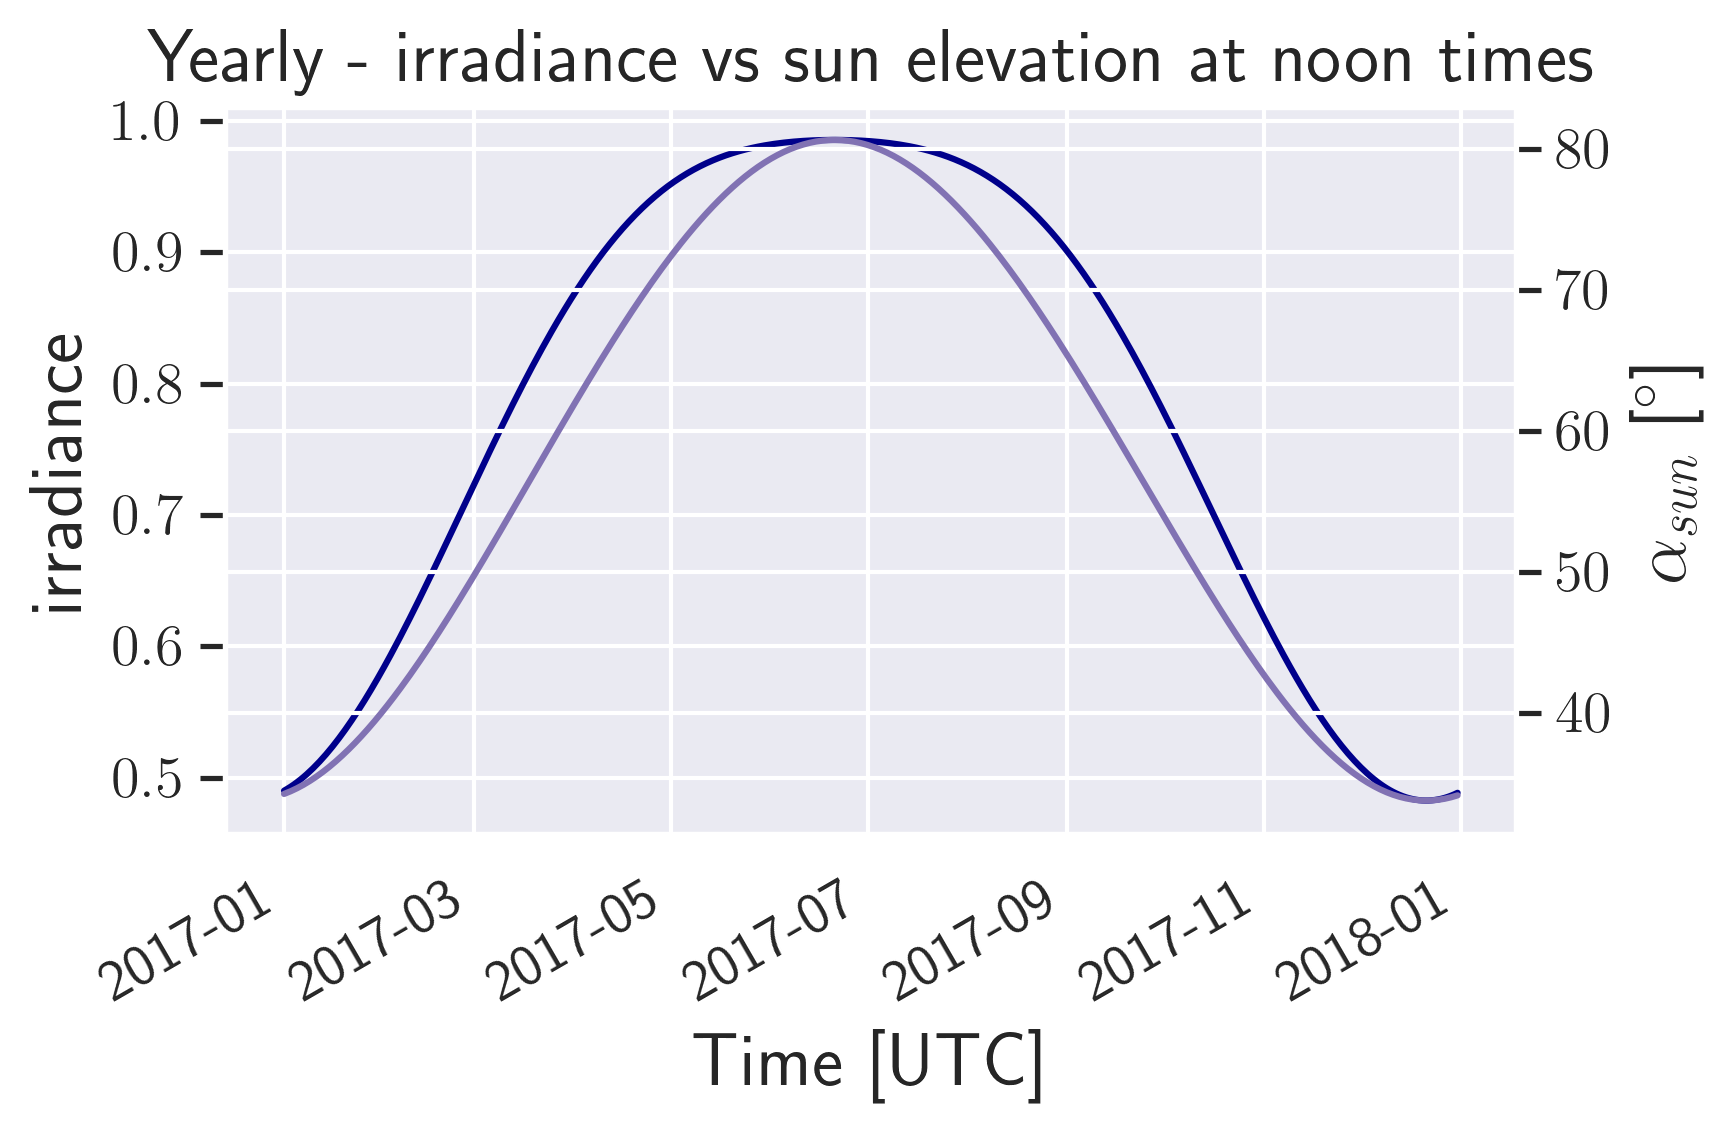

In [19]:
# %% Irradiance vs sun elevation
fig, ax = plt.subplots()
ds_year= ds_year.assign(irradiance =  xr.apply_ufunc(lambda alpha:
                                                     func_cos(alpha,popt[0],popt[1],popt[2],popt[3]),
                                                     ds_year.sunelevation, keep_attrs = True))
ds_year.irradiance.name='irradiance'
ds_year.irradiance.attrs={'long_name':'irradiance'}

ds_year.irradiance.plot(ax=ax)
ax1 = ax.twinx()
ds_year.sunelevation.plot(ax=ax1,c='m')
ax.set_title('Yearly - irradiance vs sun elevation at noon times')
plt.tight_layout()
plt.show()
# %%

### 2. Ratio elevation per day (at noon time)

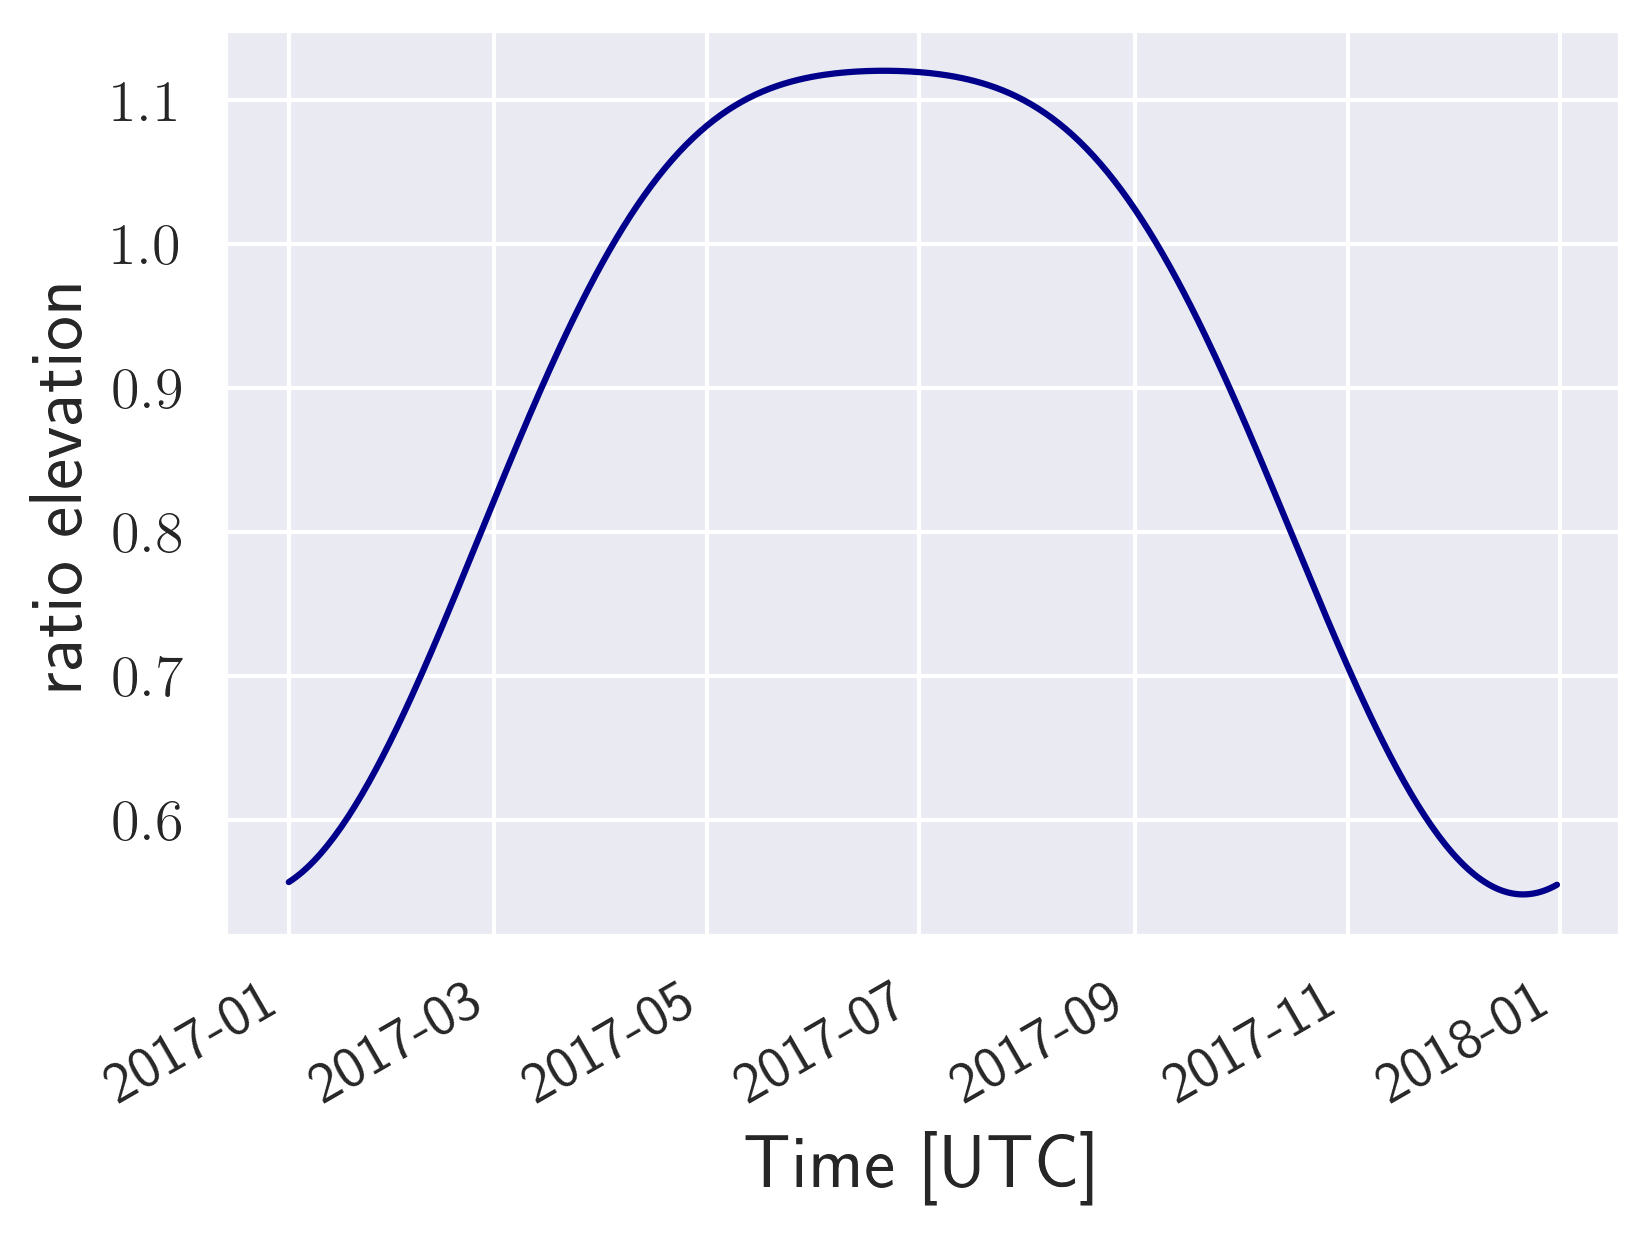

In [20]:
# %%Ratio elevation per day
irradiance_0 = func_cos(max_elevation_0,popt[0],popt[1],popt[2],popt[3])
ds_year = ds_year.assign(relevation =  xr.apply_ufunc(lambda x,y: x/y, ds_year.irradiance,
                                                      irradiance_0,keep_attrs = True))
ds_year.relevation.name='ratio elevation'
ds_year.relevation.attrs={'long_name':'ratio elevation'}
ds_year.relevation.plot()
plt.show()
# %%

### 3. Daylight time (hours) per day
> Or bins where there are 120 bins per one hour.

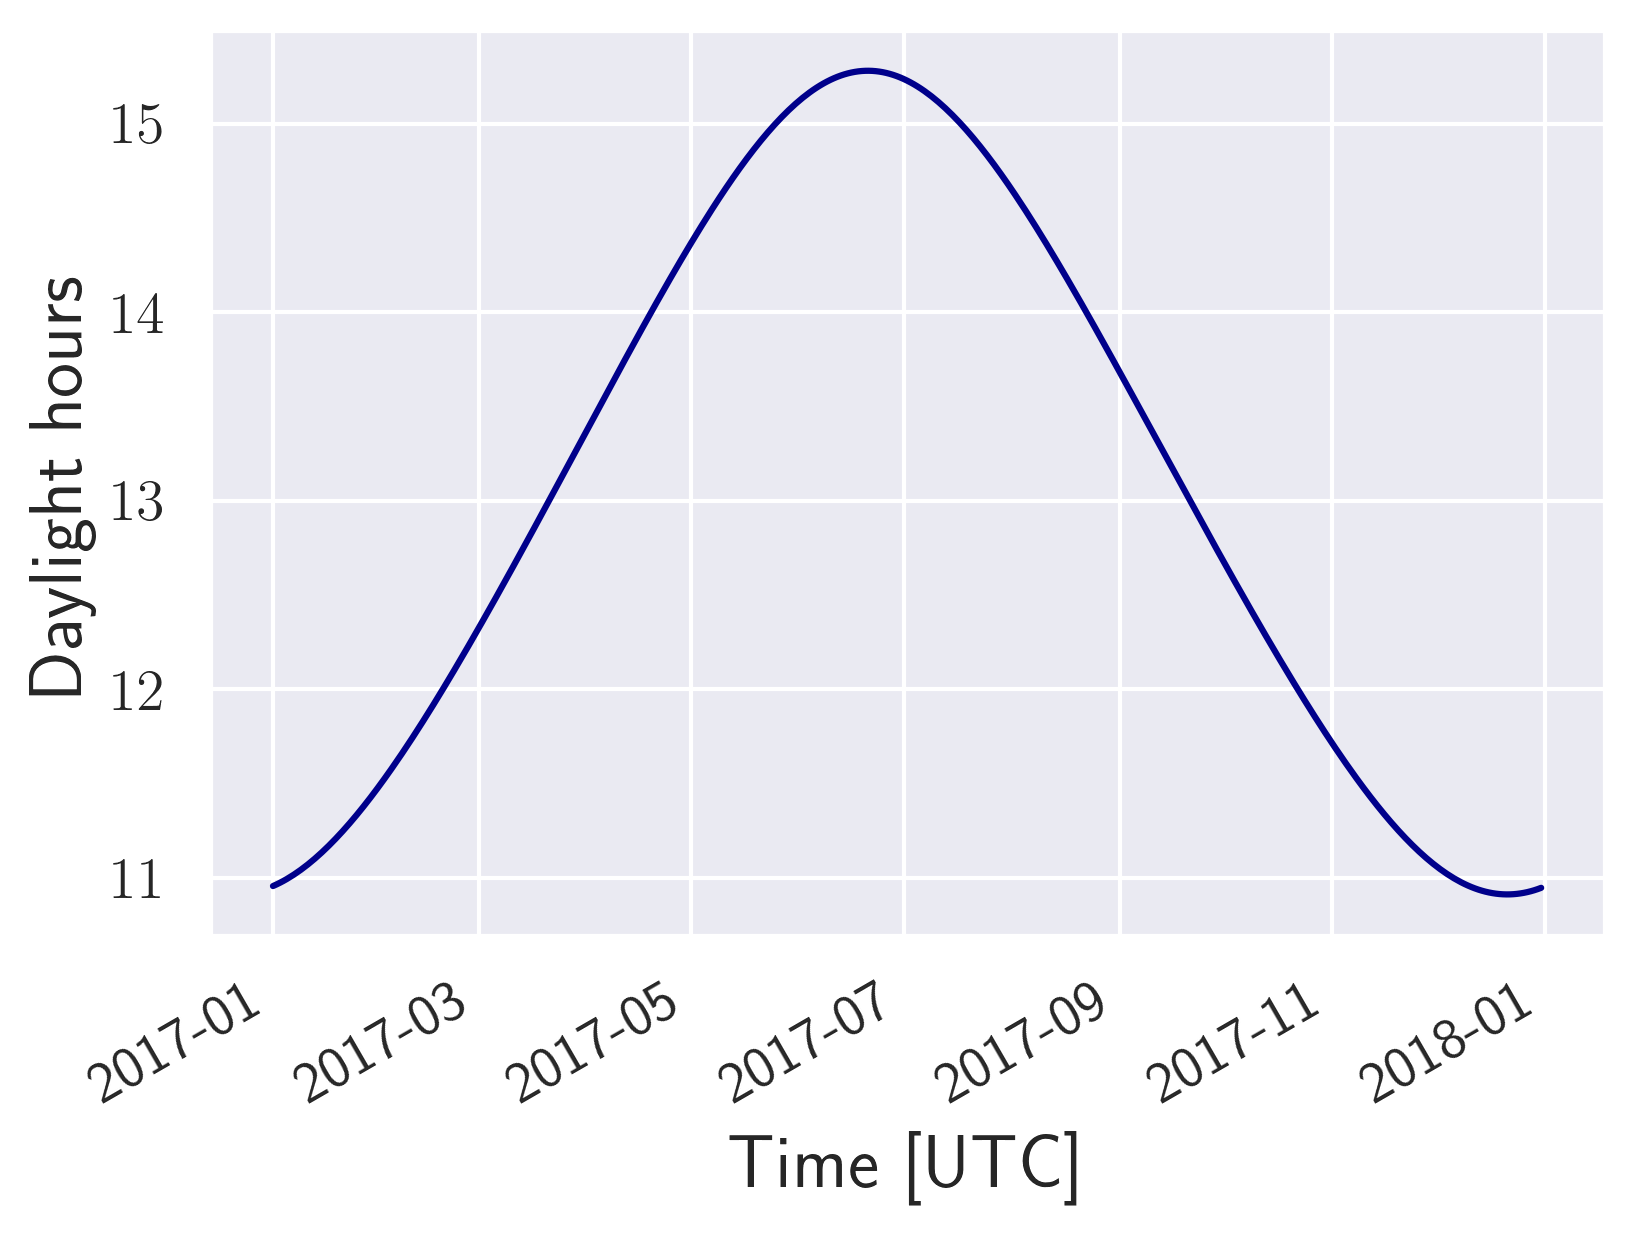

In [21]:
# %%Daylight time per day
daylight_timedelta = np.array([sun_dt(c_day,'dusk')-sun_dt(c_day,'dawn') for c_day in year_days])
daylight_time = np.array([dt_delta2time(dt) for dt in daylight_timedelta])
daylight_bins = np.array([dt2binscale(dt) for dt in daylight_time])
ds_year = ds_year.assign( daylightbins = xr.Variable(dims ={'Time':ds_year.Time} ,
                                                     data=daylight_bins,
                                                     attrs={'long_name': 'Daylight bins','info':'dDaylight bins count per day'}),
 daylighthrs = xr.Variable(dims ={'Time':ds_year.Time} ,data=daylight_bins/120,
                                                     attrs={'long_name': 'Daylight hours', 'info':'Daylight hours per day'}))
ds_year.daylighthrs.plot()
plt.show()
# %%

### 4. Calculating Gaussian curve parameters for any day of 2017
<MAIN>

In [4]:
# %%Calculating Gaussian curve parameters for any day of 2017 #TODO: this section requires massive re-organisation and commenting
start_day = datetime(2017,1,1)
end_day = datetime(2018,1,1) - timedelta(seconds = station.freq)
max_new_curves = []
min_new_curves = []
mean_new_curves = []
mean_new_signal = []
for i,(curve_h,curve_l,mean_val,chan) in \
        enumerate(zip(high_curves,low_curves,mean_curves,['UV','G','IR'])):
	prms_h = params[chan]['high']
	prms_l = params[chan]['low']
	t0 = bins_ratio*prms_l['t0']- day_bins_length_0/2
	t1 = bins_ratio*prms_l['t0']+ day_bins_length_0/2

	"""Calculating low curves """
	A_l_ds = xr.apply_ufunc(lambda x: prms_l['A']*factors[i]*x,
	                        ds_year.relevation,keep_attrs = True)
	H_l_ds = xr.apply_ufunc(lambda x: prms_l['H']*factors[i]*x,
                        ds_year.relevation,keep_attrs = True)
	# calculating dx_l for 4/4/2017
	dx_l = (tbin_noon_tst_0-(bins_ratio*prms_l['t0']))/day_bins_length_0
	t0_l_ = [(dt2binscale(tnoon)-dx_l*daylight) for tnoon,daylight in zip(sun_noons,ds_year.daylightbins.values)]
	t0_l_ds = H_l_ds.copy(deep=True)
	t0_l_ds.data = t0_l_
	photons_twilight_l = 0.5*(curve_l[int(t1)]+ curve_l[int(t0)])
	max_val_ds = xr.apply_ufunc(lambda ratio: (prms_l['H']+prms_l['A'])*ratio*factors[i],
	                            ds_year.relevation,keep_attrs = True)
	min_val_ds = xr.apply_ufunc(lambda ratio: (prms_l['A'])*ratio*factors[i],
                            ds_year.relevation,keep_attrs = True)
	W_l_ds = xr.apply_ufunc(lambda min_val,max_val,daylight:
	                        calc_gauss_width(min_val, max_val, photons_twilight_l, daylight),
	                        min_val_ds ,max_val_ds,ds_year.daylightbins,keep_attrs = True)
	min_new = np.array([calc_gauss_curve(t,A,H,t0,W)
	                    for A,H,t0,W in zip(A_l_ds.values,H_l_ds.values,t0_l_ds.values,W_l_ds.values)])
	min_new_curves.append(min_new)

	"""Calculating high curves """

	A_h_ds = xr.apply_ufunc(lambda x: prms_h['A']*factors[i]*x,
	                        ds_year.relevation,keep_attrs = True)
	H_h_ds = xr.apply_ufunc(lambda x: prms_h['H']*factors[i]*x,
                        ds_year.relevation,keep_attrs = True)
	# calculating dx_h for 4/4/2017
	dx_h = (tbin_noon_tst_0-(bins_ratio*prms_h['t0']))/day_bins_length_0
	t0_h_ = [(dt2binscale(tnoon)-dx_h*daylight)
	         for tnoon,daylight in zip(sun_noons,ds_year.daylightbins.values)]
	t0_h_ds = t0_l_ds.copy(deep = True)
	t0_h_ds.data = t0_h_
	photons_twilight_h = 0.5*(curve_h[int(t1)]+ curve_h[int(t0)])
	max_val_ds = xr.apply_ufunc(lambda ratio: (prms_h['H']+prms_h['A'])*ratio*factors[i],
                            ds_year.relevation,keep_attrs = True)
	min_val_ds = xr.apply_ufunc(lambda ratio: (prms_h['A'])*ratio*factors[i],
                        ds_year.relevation,keep_attrs = True)
	W_h_ds = xr.apply_ufunc(lambda min_val,max_val,daylight:
                        calc_gauss_width(min_val, max_val, photons_twilight_h, daylight),
                        min_val_ds ,max_val_ds,ds_year.daylightbins,keep_attrs = True)
	max_new = np.array([calc_gauss_curve(t,A,H,t0,W)
	           for A,H,t0,W in zip(A_h_ds.values,H_h_ds.values,t0_h_ds.values,W_h_ds.values)])
	max_new_curves.append(max_new)

	"""Calculating mean curves & generating new averaged bg signal """
	mean_new = (0.5*(max_new+min_new))
	mean_new_curves.append(mean_new)
	std_val = (0.5*(max_new-min_new))
	bg_new_sig = np.zeros((len(ds_year.Time),bins_per_day))
	for day in range(len(ds_year.Time)):
		bg_new_sig[day,:]  = (mean_new[day].reshape(bins_per_day,1) + np.diagflat(std_val[day])@np.random.randn(bins_per_day,1)).T
	bg_new_sig[bg_new_sig<0]=eps
	mean_new_signal.append(bg_new_sig)
# %% Generating background dataset per year
ds_bins = pd.date_range(start = start_day,
                        end = end_day,
                        freq = '30S',
                        tz = 'UTC')
bg_channels = []
for ind,wavelength in enumerate(wavelengths):
	bg_channels.append(xr.Dataset( data_vars = {'bg':(('Time'), mean_new_signal[ind].flatten())},
                         coords = {'Time':ds_bins.values,'Wavelength':wavelength}))
ds_bg_year = xr.concat(bg_channels,dim = 'Wavelength')
ds_bg_year.Wavelength.attrs={'long_name':r'$\lambda$','units':r'$\rm nm$'}
ds_bg_year.bg.attrs={'long_name':r'$<p_{\rm bg}>$', 'units':r'$\rm photons$','info':'Daily averaged background signal'}
# %%

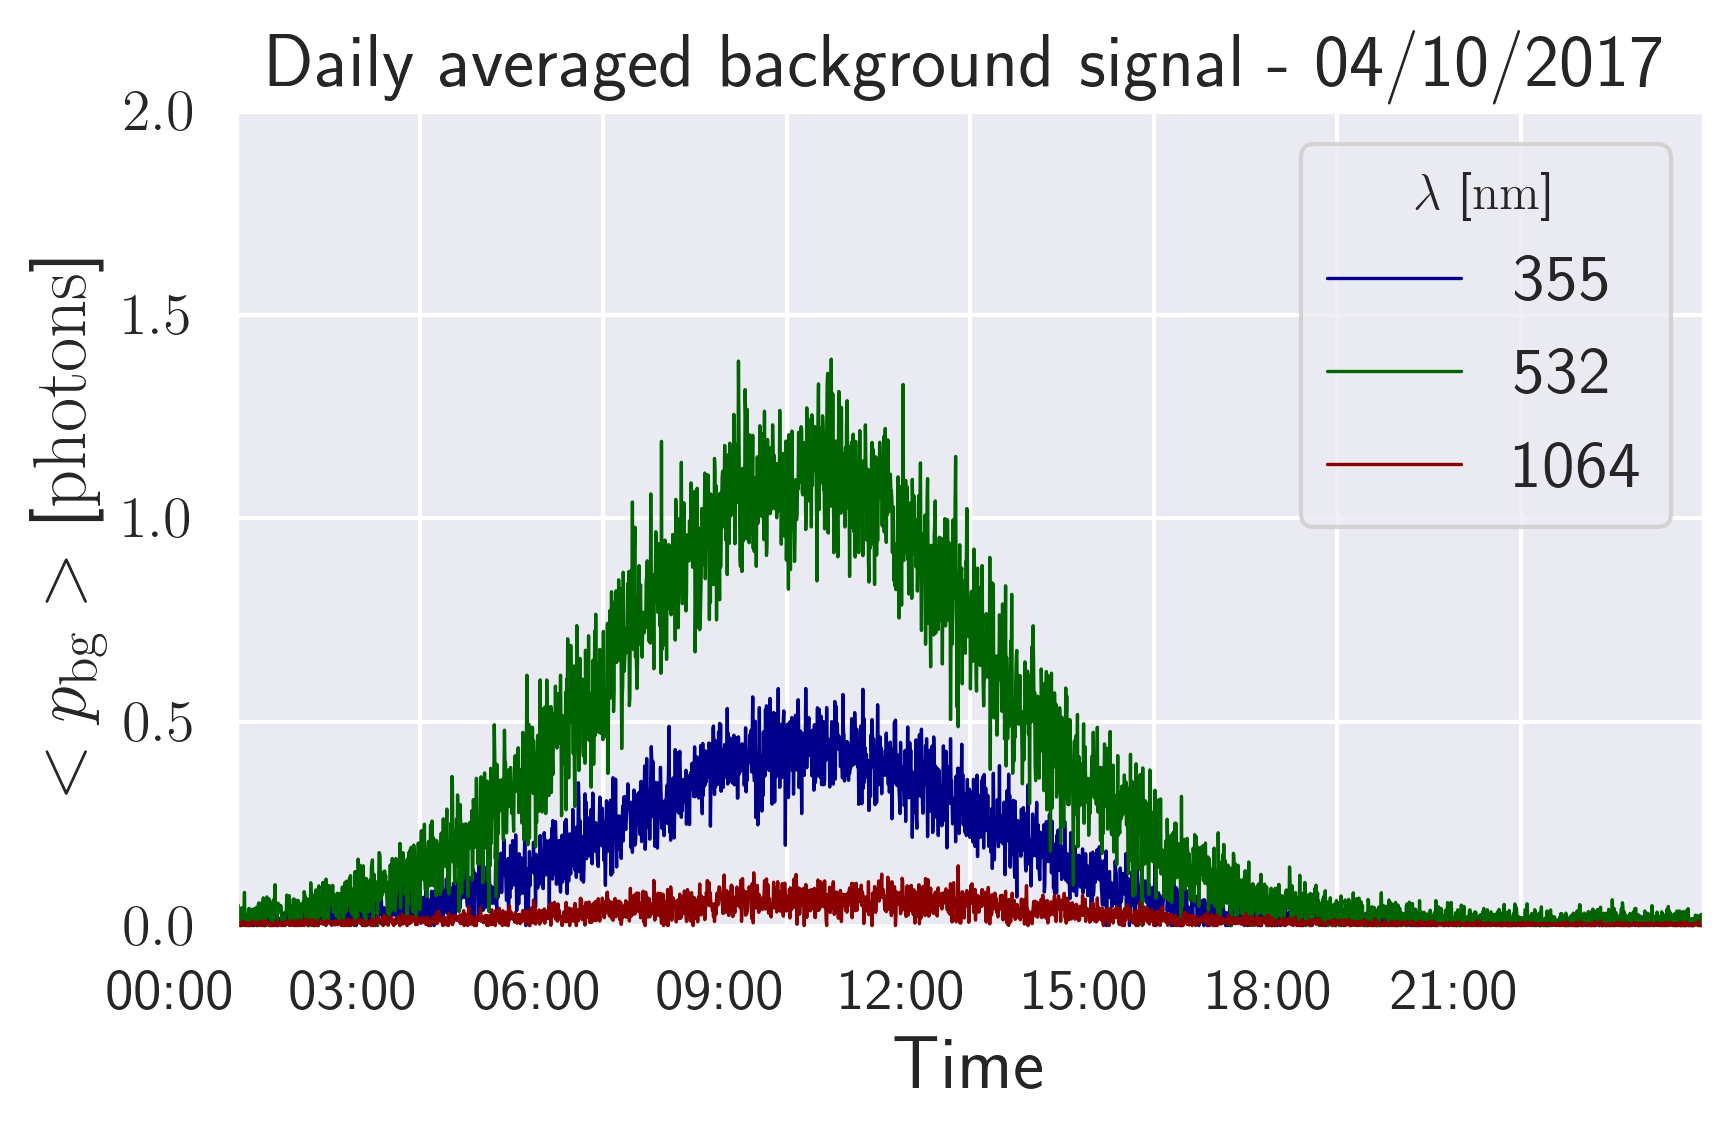

In [24]:
# %%Plot current day
c_day = cur_day
dslice = slice(c_day,c_day+timedelta(days = 1)-timedelta(seconds = 30))
fig, ax = plt.subplots(ncols=1,nrows=1)
ds_bg_year.sel(Time = dslice).bg.plot(hue='Wavelength', ax=ax,linewidth=0.8)
ax.set_xlim([dslice.start,dslice.stop])
ax.set_title(f"{ds_bg_year.bg.info} - {c_day.strftime('%d/%m/%Y')}")
ax.xaxis.set_major_formatter(vis_utils.TIMEFORMAT)
ax.xaxis.set_tick_params(rotation=0)
ax.set_ybound([-.01,2])
plt.tight_layout()
plt.show()
# %%

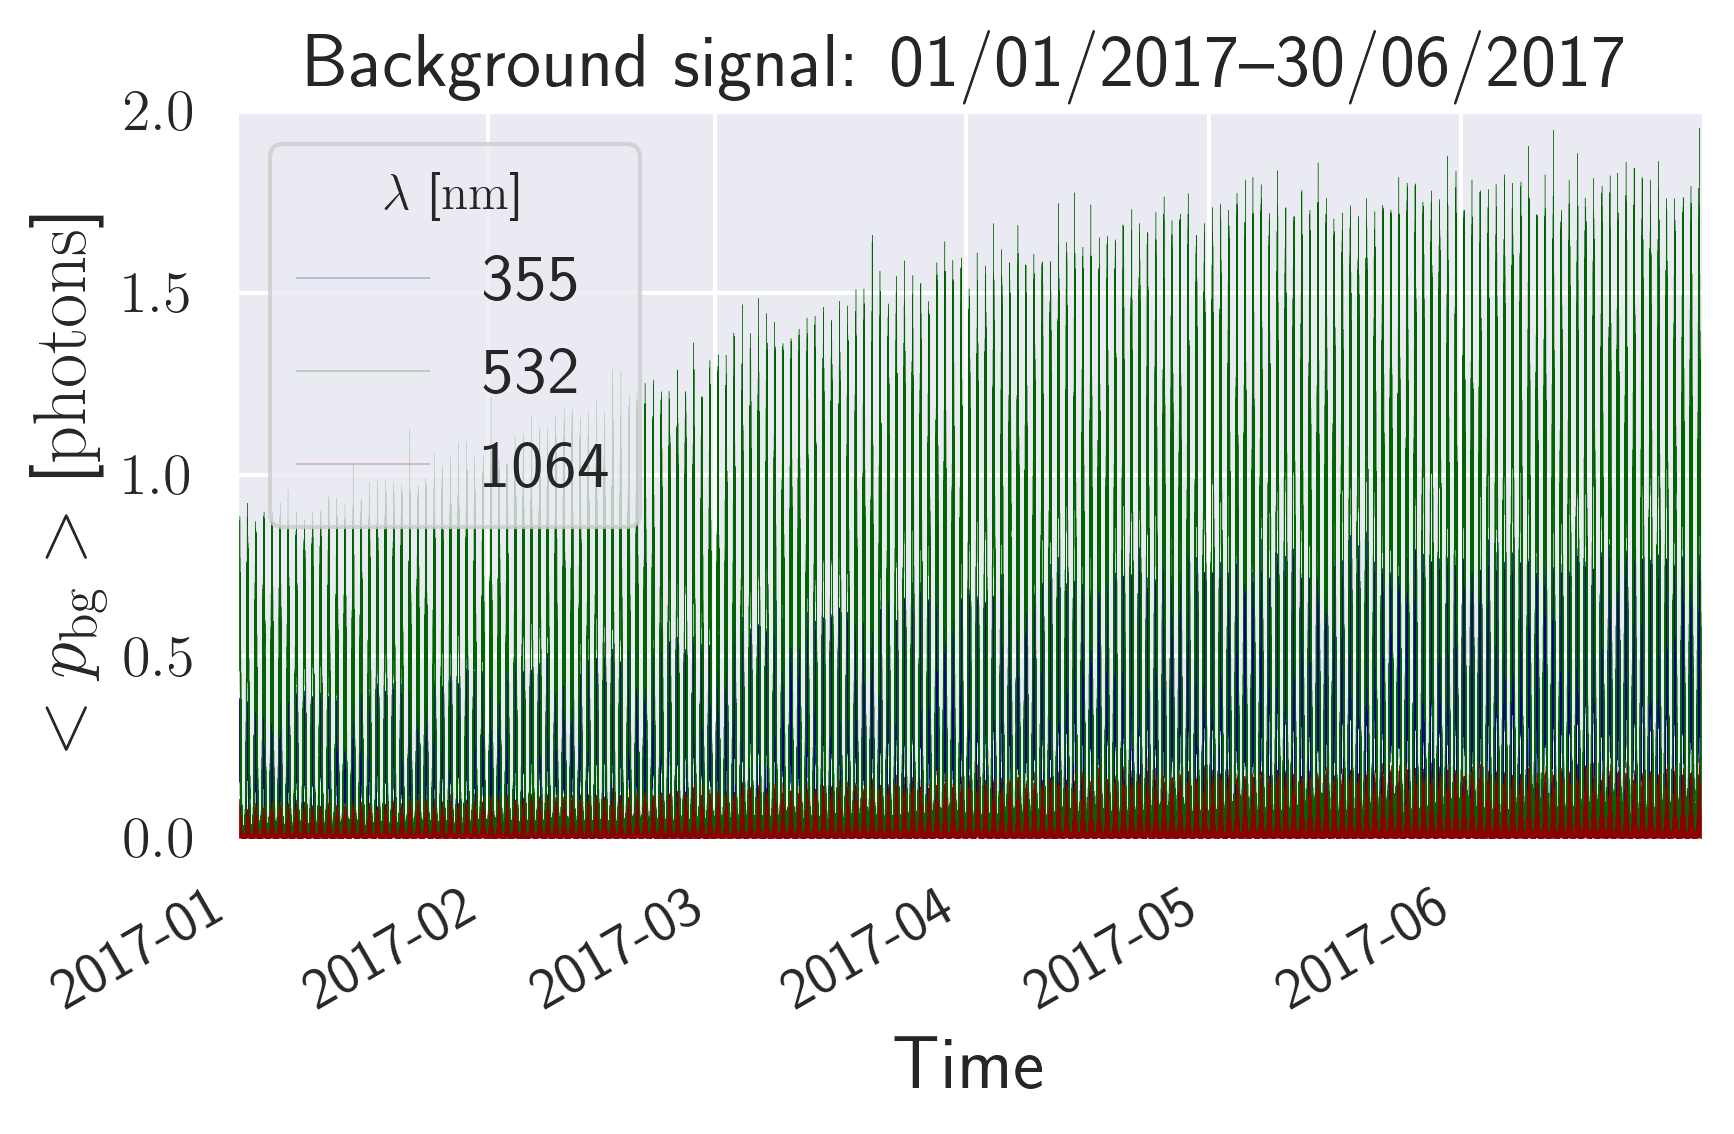

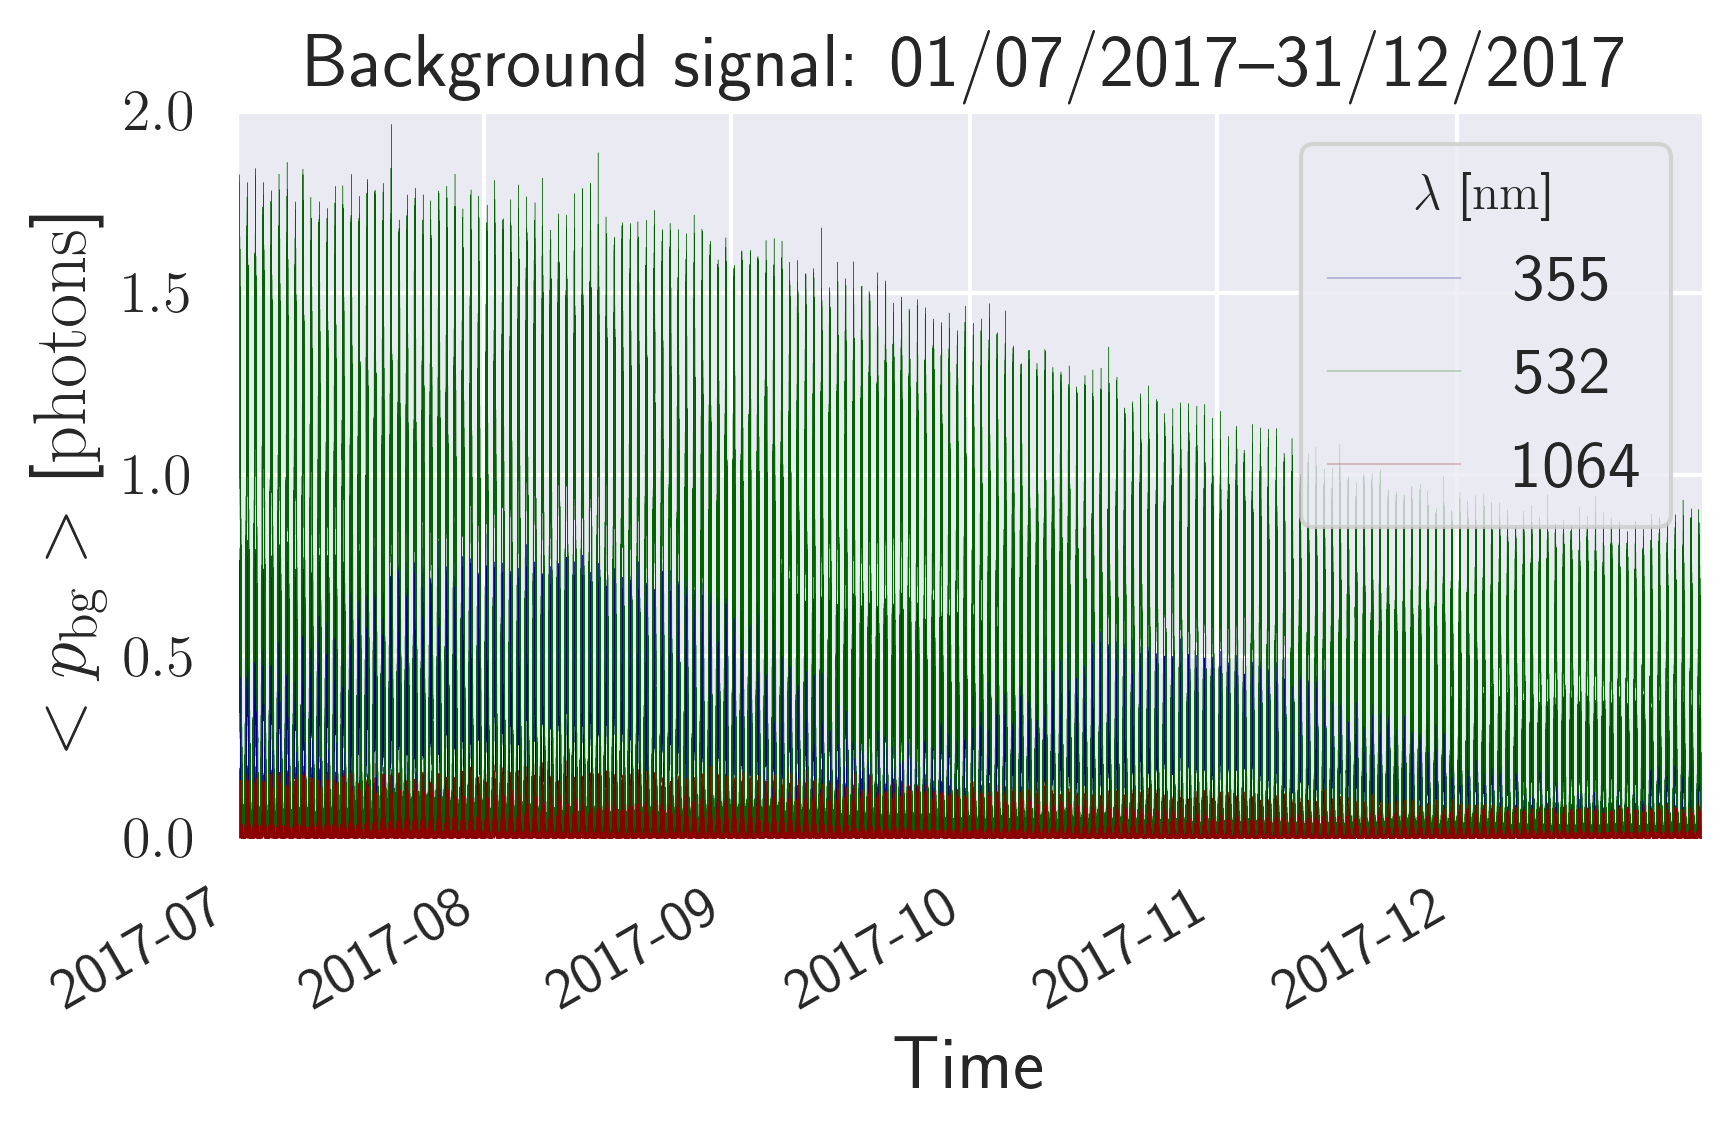

In [25]:
# %% Plot 1st half of the year
c_day = datetime(2017,1,1)
dslice = slice(c_day,c_day+timedelta(days = 181)-timedelta(seconds = 30))
fig, ax = plt.subplots(ncols=1,nrows=1)
ds_bg_year.sel(Time = dslice).bg.plot(hue = 'Wavelength',ax=ax,linewidth=0.1)
ax.set_xlim([dslice.start,dslice.stop])
ax.set_title(f"Background signal: {dslice.start.strftime('%d/%m/%Y')}--{dslice.stop.strftime('%d/%m/%Y')}")
ax.set_ybound([-.01,2])
plt.tight_layout()
plt.show()

# %% Plot 2nd half of the year
c_day = datetime(2017,7,1)
dslice = slice(c_day,c_day+timedelta(days = 184)-timedelta(seconds = 30))
fig, ax = plt.subplots(ncols=1,nrows=1)
ds_bg_year.sel(Time = dslice).bg.plot(hue = 'Wavelength',ax=ax,linewidth=0.1)
ax.set_xlim([dslice.start,dslice.stop])
ax.set_title(f"Background signal: {dslice.start.strftime('%d/%m/%Y')}--{dslice.stop.strftime('%d/%m/%Y')}")
ax.set_ybound([-.01,2])
plt.tight_layout()
plt.show()
# %%

In [6]:
# %%save yearly dataset
folder_name =  station.generation_folder
nc_name = f"generated_bg_{station.name}_" \
          f"{start_day.strftime('%Y-%m-%d')}_{end_day.strftime('%Y-%m-%d')}.nc"
prep.save_dataset ( ds_bg_year , folder_name , nc_name )

# %% Save monthly bg dataset
year = start_day.year
for month in range(1,12+1):
    last = (calendar.monthrange(year,month)[1])
    start_dt = datetime(year,month,1)
    end_dt = datetime(year,month,last) + timedelta(days=1) - timedelta(seconds =  station.freq)
    gen_source_path = gen_utils.get_month_gen_params_path(station,start_dt,type='bg')
    month_slice = slice(start_dt,end_dt)
    xr_utils.save_dataset (dataset= ds_bg_year.sel(Time=month_slice) , nc_path=gen_source_path)
# %% TODOS

<xarray.Dataset>
Dimensions:     (Time: 1051200, Wavelength: 3)
Coordinates:
  * Time        (Time) datetime64[ns] 2017-01-01 ... 2017-12-31T23:59:30
  * Wavelength  (Wavelength) int64 355 532 1064
Data variables:
    bg          (Wavelength, Time) float64 0.006997 2.22e-16 ... 0.001114

Final TODOS:
> TODOs:
#### 1. Adjust section 4 - to run for any given period with start_day, end_day
#### 2. Save the curve parameters per day : A_l, H_l, W_l, t0_l and  A_h, H_h, W_h, t0_h
> A_l_ds, H_l_ds, W_l_ds , t0_l_ds, A_h_ds, H_h_ds, W_h_ds , t0_h_ds
#### 2.  Save the bounding curves per day :  max_new_curves, min_new_curves, mean_new_curves
> similar to the way ds_bg_year was generated

